In [1]:
# Install required libraries in Colab
# !pip install spacy networkx seaborn

# (Optional) Download a Spacy language model
!python -m spacy download en_core_web_lg

# Import libraries
# import pandas as pd
# import numpy as np
# import spacy
# import networkx as nx
# import matplotlib.pyplot as plt
# import seaborn as sns
# from typing import List, Dict, Any
# import re
# import warnings

# Ignore warnings
# warnings.filterwarnings("ignore")

print("All required libraries have been installed and imported.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 5.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
All required libraries have been installed and imported.


Loaded 1509 website articles
Loaded 143 PDF articles
total_entities: 6542
total_relationships: 33488
top_entities_by_connections: {'United States': 1358, 'China': 1004, 'Singapore': 798, 'Russia': 566, 'United Nations': 452, 'Ukraine': 400, 'Reuters': 396, 'Japan': 384, 'ITF': 302, 'KTA': 290}
entity_type_distribution: {'PEOPLE': 2546, 'ORGANIZATIONS': 2942, 'LOCATIONS': 1036, 'CONCEPTS': 8, 'EVENTS': 10}


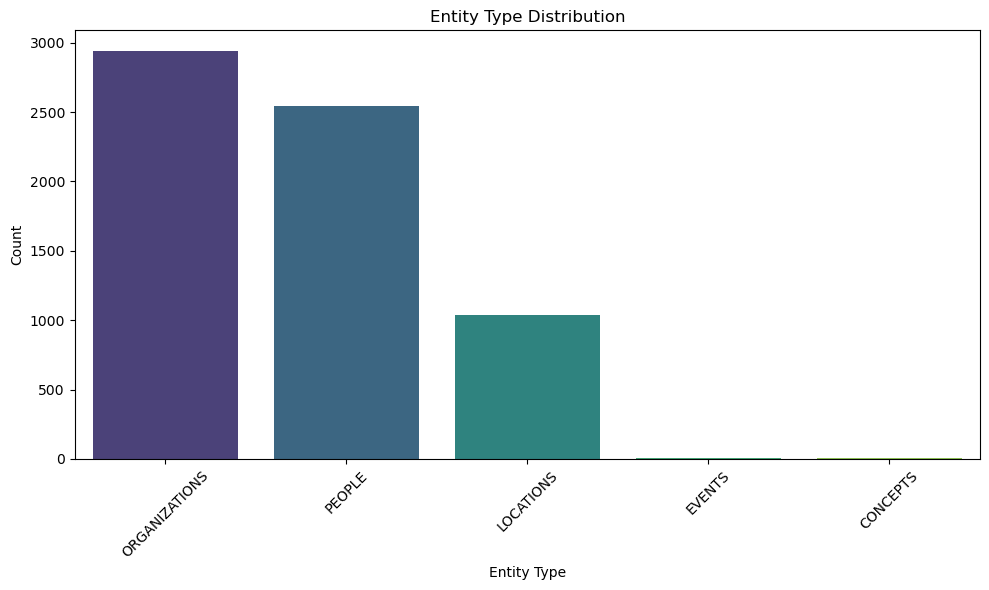

In [1]:
import pandas as pd
import numpy as np
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import re
import warnings

class TextAnalyticsTool:
    def __init__(self, model='en_core_web_lg'):
        try:
            self.nlp = spacy.load(model)
        except OSError:
            print(f"Model {model} not found. Please download using: python -m spacy download {model}")
            raise

        self.websites_data = None
        self.pdfs_data = None
        self.entity_graph = nx.MultiDiGraph()

        # Entity normalization mapping
        self.ENTITY_NORMALIZATION_MAP = {
            "U.S.": "United States",
            "US": "United States",
            "USA": "United States",
            "the United States": "United States",
            "The United States": "United States",
            "America": "United States",
            "Donald Trump": "Donald Trump",
            "Trump": "Donald Trump",
            "George W. Bush": "George W. Bush",
            "George Bush": "George W. Bush",
            "Bush": "George W. Bush",
            "the United Arab Emirates": "UAE",
            "Biden": "Joe Biden",
            "the United Arab Emirates": "UAE",
            "Türkiye": "Turkey",
            "the Gaza Strip": "Gaza",
            "UN" : "United Nations",
            "SINGAPORE": "Singapore",
            "the European Union" : "European Union",
            "The European Union": "European Union",
            "North Korea's": "North Korea",
            "South Korea's": "South Korea",
            "UNMIK Regulation No 1/1999": "UNMIK",
            "Amazon.com": "Amazon",
            "the Ministry of Health": "Ministry of Health",
            "MOH": "Ministry of Health",
            "NTU": "Nanyang Technological University",
            "MFA": "Ministry of Foreign Affairs",
            "the Ministry of Foreign Affairs": "Ministry of Foreign Affairs"

            # Add more mappings as needed
        }

        # Custom mappings for misidentified entities
        self.CUSTOM_ENTITY_MAP = {
            "CNA": "Organization", #"Location"
            "COVID-19" : "Events",
            "Neymar" : "People"

        }

    def load_data(self, websites_path: str, pdfs_path: str):
        try:
            # Load datasets
            self.websites_data = pd.read_excel(websites_path)
            self.pdfs_data = pd.read_excel(pdfs_path)

            # Validate datasets
            self._validate_data(self.websites_data, source_type="Websites")
            self._validate_data(self.pdfs_data, source_type="PDFs")

            print(f"Loaded {len(self.websites_data)} website articles")
            print(f"Loaded {len(self.pdfs_data)} PDF articles")

        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def _validate_data(self, dataframe: pd.DataFrame, source_type: str):
        # Ensure DataFrame is not empty
        if dataframe.empty:
            raise ValueError(f"{source_type} dataset is empty.")

        # Infer possible column names
        possible_source_cols = ['Link', 'PDF Path']
        possible_text_cols = ['Text']

        # Find the matching columns
        source_col = next((col for col in dataframe.columns if col in possible_source_cols), None)
        text_col = next((col for col in dataframe.columns if col in possible_text_cols), None)

        if not source_col or not text_col:
            raise ValueError(f"{source_type} dataset is missing required columns for 'Source' or 'Text'. "
                            f"Ensure the dataset includes a source-like column ({possible_source_cols}) "
                            f"and a text-like column ({possible_text_cols}).")

        # Check for missing values
        if dataframe[source_col].isnull().any():
            raise ValueError(f"{source_type} dataset contains missing values in the '{source_col}' column.")
        if dataframe[text_col].isnull().any():
            raise ValueError(f"{source_type} dataset contains missing values in the '{text_col}' column.")

    def normalize_entity(self, entity: str) -> str:
        """
        Normalizes an entity to its canonical form using ENTITY_NORMALIZATION_MAP.
        """
        return self.ENTITY_NORMALIZATION_MAP.get(entity.strip(), entity)

    def post_process_entity(self, entity: str, entity_type: str) -> str:
        """
        Post-process entities to handle misclassifications or custom mappings.
        """
        # Check if there's a custom mapping for this entity
        if entity in self.CUSTOM_ENTITY_MAP:
            # Override the entity type based on the custom mapping
            entity_type = self.CUSTOM_ENTITY_MAP[entity]
        return entity_type

    def extract_entities(self, text: str) -> Dict[str, List[str]]:
        if not text or not isinstance(text, str):
            return {}

        doc = self.nlp(text[:10000])  # Limit text length to prevent processing issues

        entities = {
            'PEOPLE': [],
            'ORGANIZATIONS': [],
            'LOCATIONS': [],
            'EVENTS': [],
            'CONCEPTS': []
        }

        # Extract and normalize entities
        for ent in doc.ents:
            normalized_entity = self.normalize_entity(ent.text)
            entity_type = ent.label_

            # Post-process to handle misclassifications or apply custom mappings
            entity_type = self.post_process_entity(normalized_entity, entity_type)

            if entity_type == 'PERSON':
                entities['PEOPLE'].append(normalized_entity)
            elif entity_type == 'ORG':
                entities['ORGANIZATIONS'].append(normalized_entity)
            elif entity_type in ['GPE', 'LOC']:
                entities['LOCATIONS'].append(normalized_entity)

        # Custom keyword extraction for Events and Concepts
        event_keywords = ['conference', 'summit', 'meeting', 'forum', 'symposium']
        concept_keywords = ['technology', 'innovation', 'strategy', 'development']

        for keyword in event_keywords:
            events = re.findall(rf'\b{keyword}\b', text, re.IGNORECASE)
            entities['EVENTS'].extend(events)

        for keyword in concept_keywords:
            concepts = re.findall(rf'\b{keyword}\b', text, re.IGNORECASE)
            entities['CONCEPTS'].extend(concepts)

        # Remove duplicates while preserving order
        for key in entities:
            entities[key] = list(dict.fromkeys(entities[key]))

        return entities

    def build_entity_network(self):
        def process_dataframe(dataframe, source_type):
            for _, row in dataframe.iterrows():
                text = str(row.iloc[1])  # Assuming second column contains text
                source = str(row.iloc[0])  # First column as source identifier

                entities = self.extract_entities(text)

                # Add nodes and edges to graph
                for entity_type, entity_list in entities.items():
                    for entity in entity_list:
                        # Add node with type information
                        self.entity_graph.add_node(entity, type=entity_type, source_type=source_type)

                        # Create relationships between entities in the same text
                        for related_entity in entity_list:
                            if entity != related_entity:
                                self.entity_graph.add_edge(entity, related_entity, type=entity_type)

        # Process both datasets
        process_dataframe(self.websites_data, 'website')
        process_dataframe(self.pdfs_data, 'pdf')

    def generate_insights(self):
        insights = {
            'total_entities': self.entity_graph.number_of_nodes(),
            'total_relationships': self.entity_graph.number_of_edges(),
            'top_entities_by_connections': dict(sorted(dict(self.entity_graph.degree).items(),
                                                       key=lambda x: x[1],
                                                       reverse=True)[:10]),
            'entity_type_distribution': {}
        }

        # Count entities by type
        for node, data in self.entity_graph.nodes(data=True):
            entity_type = data.get('type', 'Unknown')
            insights['entity_type_distribution'][entity_type] = \
                insights['entity_type_distribution'].get(entity_type, 0) + 1

        return insights

    def plot_entity_distribution(self):
        entity_types = [data['type'] for _, data in self.entity_graph.nodes(data=True)]
        type_counts = pd.Series(entity_types).value_counts()

        plt.figure(figsize=(10, 6))
        sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')
        plt.title("Entity Type Distribution")
        plt.ylabel("Count")
        plt.xlabel("Entity Type")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


def main():
    tool = TextAnalyticsTool()
    tool.load_data(
        websites_path='data/Copy of news_excerpts_parsed.xlsx',
        pdfs_path='data/Copy of wikileaks_parsed.xlsx'
    )
    tool.build_entity_network()
    insights = tool.generate_insights()
    for key, value in insights.items():
        print(f"{key}: {value}")
    tool.plot_entity_distribution()


if __name__ == "__main__":
    main()


In [2]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import math

class InteractiveNetworkGraph:
    def __init__(self, graph):
        self.graph = graph
        self.full_graph = graph

    def generate_interactive_html(self, output_path='entity_network.html', initial_top_n_nodes=200):
        self.color_map = {
            'PEOPLE': 'skyblue',
            'ORGANIZATIONS': 'lightgreen',
            'LOCATIONS': 'salmon',
            'EVENTS': 'orange',
            'CONCEPTS': 'pink'
        }

        fig = go.Figure()
        self._update_graph(fig, initial_top_n_nodes)
        max_degree = max(dict(self.graph.degree).values())

        # Update layout with vertically spaced controls
        fig.update_layout(
            title='Interactive Entity Network',
            titlefont_size=16,
            showlegend=True,
            hovermode='closest',
            margin=dict(b=20, l=5, r=250, t=40),  # Increased right margin for controls
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            # Connection filter slider
            sliders=[
                dict(
                    active=0,
                    currentvalue={"prefix": "Min. Connections: "},
                    pad={"t": 50},
                    len=0.15,
                    x=1.15,
                    y=0.2,  # Moved lower
                    xanchor="left",
                    steps=[
                        dict(
                            method="update",
                            args=[{"visible": [True] * (len(self.color_map) + 1)}],
                            label=str(i)
                        ) for i in range(0, max_degree + 1, max(1, max_degree // 10))
                    ]
                )
            ]
        )

        # Create entity filter HTML
        entity_filters_html = ""
        for entity_type, color in self.color_map.items():
            entity_filters_html += f"""
            <label style="display:block;margin-bottom:8px;">
                <input type="checkbox" value="{entity_type}" checked>
                <span style="color:{color}">{entity_type}</span>
            </label>"""

        # Create the full controls HTML
        controls_html = f"""
        <div style="position:absolute;top:180px;right:10px;z-index:1000;background:white;padding:15px;border:1px solid #ddd;border-radius:5px;">
            <div style="margin-bottom:20px;">
                <input type="text" id="searchBox" placeholder="Search nodes..."
                       style="padding:5px;width:200px;margin-bottom:15px;">
            </div>

            <div style="margin-bottom:20px;">
                <div style="font-weight:bold;margin-bottom:10px;">Entity Types:</div>
                <div id="entityFilters">
                    <label style="display:block;margin-bottom:8px;">
                        <input type="checkbox" value="all" checked> All Types
                    </label>
                    {entity_filters_html}
                </div>
            </div>
        </div>

        <script>
        document.addEventListener('DOMContentLoaded', function() {{
            var graphDiv = document.getElementsByClassName('js-plotly-plot')[0];
            var searchBox = document.getElementById('searchBox');
            var entityFilters = document.getElementById('entityFilters');

            // Handle entity type filtering
            function updateVisibility() {{
                var checkedTypes = Array.from(entityFilters.querySelectorAll('input:checked:not([value="all"])'))
                    .map(cb => cb.value);

                var allTypesCheckbox = entityFilters.querySelector('input[value="all"]');

                // Update "All Types" checkbox
                if (checkedTypes.length === {len(self.color_map)}) {{
                    allTypesCheckbox.checked = true;
                }} else {{
                    allTypesCheckbox.checked = false;
                }}

                // Get all traces
                var traces = graphDiv.data;
                var edgeTrace = traces[0];
                var nodeTraces = traces.slice(1);

                // Update node visibility
                nodeTraces.forEach(function(trace, i) {{
                    var isVisible = checkedTypes.includes(trace.name);
                    Plotly.restyle(graphDiv, {{'visible': isVisible}}, [i + 1]);
                }});

                // Update edge visibility based on connected nodes
                var edgeOpacities = new Array(edgeTrace.x.length).fill(0);
                if (checkedTypes.length > 0) {{
                    for (var i = 0; i < edgeTrace.x.length; i += 3) {{
                        var connected = false;
                        // Check if either end of the edge connects to a visible node type
                        for (var j = 0; j < nodeTraces.length; j++) {{
                            if (!checkedTypes.includes(nodeTraces[j].name)) continue;

                            for (var k = 0; k < nodeTraces[j].x.length; k++) {{
                                if ((nodeTraces[j].x[k] === edgeTrace.x[i] &&
                                     nodeTraces[j].y[k] === edgeTrace.y[i]) ||
                                    (nodeTraces[j].x[k] === edgeTrace.x[i+1] &&
                                     nodeTraces[j].y[k] === edgeTrace.y[i+1])) {{
                                    connected = true;
                                    break;
                                }}
                            }}
                            if (connected) break;
                        }}
                        edgeOpacities[i] = connected ? 1 : 0;
                        edgeOpacities[i+1] = connected ? 1 : 0;
                        edgeOpacities[i+2] = connected ? 1 : 0;
                    }}
                }}
                Plotly.restyle(graphDiv, {{'line.opacity': [edgeOpacities]}}, [0]);
            }}

            // Handle search filtering
            searchBox.addEventListener('input', function(e) {{
                var searchTerm = e.target.value.toLowerCase();
                var traces = graphDiv.data.slice(1);  // Skip edge trace

                traces.forEach(function(trace, traceIndex) {{
                    if (!trace.text) return;

                    var newOpacities = trace.text.map(function(text) {{
                        return text.toLowerCase().includes(searchTerm) ? 1 : 0.1;
                    }});

                    Plotly.restyle(graphDiv, {{
                        'marker.opacity': [newOpacities]
                    }}, [traceIndex + 1]);
                }});
            }});

            // Handle entity type checkboxes
            entityFilters.addEventListener('change', function(e) {{
                if (e.target.type === 'checkbox') {{
                    if (e.target.value === 'all') {{
                        // Set all checkboxes to match "All Types"
                        entityFilters.querySelectorAll('input:not([value="all"])')
                            .forEach(cb => cb.checked = e.target.checked);
                    }}
                    updateVisibility();
                }}
            }});
        }});
        </script>
        """

        # Save to HTML with improved controls
        with open(output_path, 'w') as f:
            html_str = fig.to_html(
                include_plotlyjs=True,
                full_html=True,
                default_height='800px'
            )
            html_str = html_str.replace('</body>', controls_html + '</body>')
            f.write(html_str)

        print(f"Interactive network graph saved to {output_path}")

    def _update_graph(self, fig, top_n_nodes):
        # Get top nodes by degree
        top_nodes = sorted(self.graph.degree, key=lambda x: x[1], reverse=True)[:top_n_nodes]
        top_node_names = [node for node, _ in top_nodes]

        # Create subgraph with top nodes
        subgraph = self.graph.subgraph(top_node_names)

        # Calculate layout
        pos = nx.spring_layout(subgraph, k=0.5)

        # Process edges
        edge_x, edge_y = [], []
        for edge in subgraph.edges():
            start_node, end_node = edge
            start_x, start_y = pos[start_node]
            end_x, end_y = pos[end_node]
            edge_x.extend([start_x, end_x, None])
            edge_y.extend([start_y, end_y, None])

        # Add edges
        fig.add_trace(
            go.Scatter(
                x=edge_x, y=edge_y,
                line=dict(width=0.5, color='#888'),
                hoverinfo='none',
                mode='lines',
                name='Connections'
            )
        )

        # Process and add nodes by entity type
        max_degree = max(dict(subgraph.degree).values())
        min_size, max_size = 5, 25

        for entity_type, color in self.color_map.items():
            x, y, texts, sizes = [], [], [], []

            for node in subgraph.nodes(data=True):
                if node[1].get('type', 'Unknown') == entity_type:
                    x.append(pos[node[0]][0])
                    y.append(pos[node[0]][1])

                    degree = subgraph.degree[node[0]]
                    size = min_size + (degree / max_degree) * (max_size - min_size)
                    sizes.append(size)

                    texts.append(f"{node[0]}<br>Type: {entity_type}<br>Connections: {degree}")

            if x:  # Only add trace if there are nodes of this type
                fig.add_trace(
                    go.Scatter(
                        x=x, y=y,
                        mode='markers',
                        name=entity_type,
                        hoverinfo='text',
                        text=texts,
                        marker=dict(
                            color=color,
                            size=sizes,
                            line_width=2
                        )
                    )
                )

# Usage example
tool = TextAnalyticsTool()
tool.load_data(
    websites_path='data/Copy of news_excerpts_parsed.xlsx',
    pdfs_path='data/Copy of wikileaks_parsed.xlsx'
)
tool.build_entity_network()

# Create interactive visualization
interactive_graph = InteractiveNetworkGraph(tool.entity_graph)
interactive_graph.generate_interactive_html(initial_top_n_nodes=250)

Loaded 1509 website articles
Loaded 143 PDF articles
Interactive network graph saved to entity_network.html
